In [1]:
import os
import sys
import json
import torch
import numpy as np

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt
from IPython.display import Image

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFEM import DiffNet2DFEM

from DiffNet.datasets.parametric.images import ImageIMBack
from e1_complex_immersed_background import Poisson

from DiffNet.datasets.single_instances.images import ImageIMBack as ImageIMBackSingleInstance
from e7_complex_immersed_background_single_instance import Poisson as PoissonSingleInstance

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42
Global seed set to 42
Global seed set to 42


In [2]:
def run_single_instance(input_nu_filename):
    filename = input_nu_filename # 'world_map.jpg'
    dataset = ImageIMBackSingleInstance(filename, domain_size=256)
    u_tensor = np.ones_like(dataset.domain)
    network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
    basecase = PoissonSingleInstance(network, dataset, batch_size=1, domain_size=256)

    # ------------------------
    # 1 INIT TRAINER
    # ------------------------
    logger = pl.loggers.TensorBoardLogger('.', name="cib_single")
    csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

    early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
        min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
    checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
        dirpath=logger.log_dir, filename='{epoch}-{step}',
        mode='min', save_last=True)

    trainer = Trainer(gpus=[0],callbacks=[early_stopping],
        checkpoint_callback=checkpoint, logger=[logger,csv_logger],
        max_epochs=5, deterministic=True, profiler='simple')

    trainer.fit(basecase)
    torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))
    
    inputs, forcing = basecase.dataset[0]
    nu, f, u = basecase.do_query(inputs, forcing)
    return nu, f, u

In [3]:
def query_plot_contours_and_save(dirpath,nu,f,u, saveid=None):
    outfilename = os.path.join(dirpath, 'query.png')
    if saveid != None:
        outfilename = os.path.join(dirpath, 'query_'+str(saveid)+'.png')
    # plotting
    num_query = nu.shape[0]
    plt_num_row = num_query
    plt_num_col = 2
    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(4*plt_num_col,2.4*plt_num_row),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
    for ax_row in axs:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        kp = nu[idx,:,:]
        up = u[idx,:,:]

        im0 = axs[idx][0].imshow(kp,cmap='jet')
        fig.colorbar(im0, ax=axs[idx,0])
        im1 = axs[idx][1].imshow(up,cmap='jet')
        fig.colorbar(im1, ax=axs[idx,1]) 
    # plt.savefig(outfilename)
    # plt.close('all')
    plt.show()

def query_plot_contours_and_save_SINGLEROW(dirpath,nu,f,u, saveid=None):
    outfilename = os.path.join(dirpath, 'query.png')
    if saveid != None:
        outfilename = os.path.join(dirpath, 'query_'+str(saveid)+'.png')
    # plotting
    num_query = 1
    plt_num_row = num_query
    plt_num_col = 2
    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(4*plt_num_col,2.4*plt_num_row),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
    for ax in axs:        
        ax.set_xticks([])
        ax.set_yticks([])

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        kp = nu[:,:]
        up = u[:,:]

        im0 = axs[0].imshow(kp,cmap='jet')
        fig.colorbar(im0, ax=axs[0])
        im1 = axs[1].imshow(up,cmap='jet')
        fig.colorbar(im1, ax=axs[1]) 
    # plt.savefig(outfilename)
    # plt.close('all')
    plt.show()

In [69]:
# dirname = './complex_immersed_background/version_27/selected_query_inputs'
# case_dir = './complex_immersed_background/version_27'
# dirname = './complex_immersed_background/version_29/selected_query_inputs'
# case_dir = './complex_immersed_background/version_29'
# dirname = './complex_immersed_background/version_58/selected_query_inputs'
# case_dir = './complex_immersed_background/version_58'
dirname = './complex_immersed_background/version_59/selected_query_inputs'
case_dir = './complex_immersed_background/version_59'
query_out_path = os.path.join(case_dir, 'selected_query_outputs')
if not os.path.exists(query_out_path):
    os.makedirs(query_out_path)
dataset = ImageIMBack(dirname, domain_size=256)
#network = GoodNetwork(in_channels=2, out_channels=1, in_dim=64, out_dim=64)
network = torch.load(os.path.join(case_dir, 'network.pt'))
basecase = Poisson(network, dataset, batch_size=16, domain_size=256)

nsample = len(basecase.dataset)
print("nsample = ", nsample)

nsample =  9


In [70]:
network

UNet(
  (down1): UNetDown(
    (model): Sequential(
      (0): Conv2d(2, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (down2): UNetDown(
    (model): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down3): UNetDown(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down4): UNetDown(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2)

In [71]:
for i in range(nsample//10+1):
    id0 = 10*i
    id1 = id0+10
    if id1 > nsample:
        id1 = nsample
        
    # core query code
    inputs, forcing = basecase.dataset[id0:id1]
    nu_par_list, f_par_list, u_par_list = basecase.do_query(inputs, forcing)
    # query_plot_contours_and_save(query_out_path, nu_par_list, f_par_list, u_par_list, i)

In [72]:
# Image(filename=os.path.join(query_out_path,'query.png')) 

In [73]:
query_input_filenames = os.listdir(dirname)
nu_single_list = []
u_single_list = []
f_single_list = []
for fname in query_input_filenames:
    filename = os.path.join(dirname, fname)
    file, ext = os.path.splitext(filename)
    if ext in ['.png', '.jpg', '.bmp', '.tiff']:
        nu, f, u = run_single_instance(filename)
        nu_single_list.append(nu)
        f_single_list.append(f)
        u_single_list.append(u)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./cib_single/version_62 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name         | Type          | Params
-----------------------------------------------
0 | network      | ParameterList | 65.5 K
1 | N_gp         | ParameterList | 16    
2 | dN_x_gp      | ParameterList | 16    
3 | dN_y_gp      | ParameterList | 16    
4 | d2N_x_gp     | ParameterList | 16    
5 | d2N_y_gp     | ParameterList | 16    
6 | d2N_xy_gp    | ParameterList | 16    
7 | N_gp_surf    | ParameterList | 4     
8 | dN_x_gp_surf | ParameterList | 4     
9 | dN_y_gp_surf | ParameterList | 4     
---------------------------------------------

Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 69.61it/s, loss=32.5, v_num=2_62]


FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  10.141         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.0198         	|5              	|  10.099         	|  99.586         	|
run_training_batch                 	|  0.01665        	|500            	|  8.3248         	|  82.091         	|
optimizer_step_and_closure_0       	|  0.016445       	|500            	|  8.2223         	|  81.08          	|
training_step_and_backward         	|  0.0023487      	|899            	|  2.1115         	|  20.821         	|
model_forward                      

Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 69.54it/s, loss=34.8, v_num=3_63]


FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  9.8661         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  1.9661         	|5              	|  9.8305         	|  99.639         	|
run_training_batch                 	|  0.016122       	|500            	|  8.0609         	|  81.703         	|
optimizer_step_and_closure_0       	|  0.015917       	|500            	|  7.9585         	|  80.665         	|
training_step_and_backward         	|  0.0023444      	|842            	|  1.974          	|  20.008         	|
model_forward                      

Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 69.55it/s, loss=30.1, v_num=4_64]


FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  10.433         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.0794         	|5              	|  10.397         	|  99.657         	|
run_training_batch                 	|  0.01724        	|500            	|  8.6199         	|  82.624         	|
optimizer_step_and_closure_0       	|  0.017035       	|500            	|  8.5175         	|  81.642         	|
training_step_and_backward         	|  0.0025176      	|867            	|  2.1828         	|  20.922         	|
model_forward                      

Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 69.47it/s, loss=30.3, v_num=5_65]


FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  10.176         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.0279         	|5              	|  10.139         	|  99.636         	|
run_training_batch                 	|  0.016713       	|500            	|  8.3567         	|  82.118         	|
optimizer_step_and_closure_0       	|  0.016507       	|500            	|  8.2537         	|  81.106         	|
training_step_and_backward         	|  0.0023468      	|882            	|  2.0699         	|  20.34          	|
model_forward                      

Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 69.19it/s, loss=34, v_num=6_66] 

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  9.8195         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  1.9568         	|5              	|  9.7841         	|  99.639         	|
run_training_batch                 	|  0.016007       	|500            	|  8.0035         	|  81.506         	|
optimizer_step_and_closure_0       	|  0.015801       	|500            	|  7.9006         	|  80.458         	|
training_step_and_backward         	|  0.002344       	|860            	|  2.0158         	|  20.529         	|
model_forward                      

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./cib_single/version_67 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name         | Type          | Params
-----------------------------------------------
0 | network      | ParameterList | 65.5 K
1 | N_gp         | ParameterList | 16    
2 | dN_x_gp      | ParameterList | 16    
3 | dN_y_gp      | ParameterList | 16    
4 | d2N_x_gp     | ParameterList | 16    
5 | d2N_y_gp     | ParameterList | 16    
6 | d2N_xy_gp    | ParameterList | 16    
7 | N_gp_surf    | ParameterList | 4     
8 | dN_x_gp_surf | ParameterList | 4     
9 | dN_y_gp_surf | ParameterList | 4     
---------------------------------------------

Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 69.36it/s, loss=34.5, v_num=7_67]


FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  10.007         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  1.9942         	|5              	|  9.9711         	|  99.64          	|
run_training_batch                 	|  0.016389       	|500            	|  8.1944         	|  81.885         	|
optimizer_step_and_closure_0       	|  0.016182       	|500            	|  8.0911         	|  80.853         	|
training_step_and_backward         	|  0.0023444      	|844            	|  1.9787         	|  19.773         	|
model_forward                      

Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 69.49it/s, loss=27.2, v_num=8_68]


FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  10.251         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.0429         	|5              	|  10.214         	|  99.643         	|
run_training_batch                 	|  0.01684        	|500            	|  8.4199         	|  82.137         	|
optimizer_step_and_closure_0       	|  0.016634       	|500            	|  8.3172         	|  81.136         	|
training_step_and_backward         	|  0.0025891      	|870            	|  2.2525         	|  21.973         	|
model_forward                      

Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 66.79it/s, loss=46.6, v_num=9_69]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  9.478          	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  1.8887         	|5              	|  9.4433         	|  99.634         	|
run_training_batch                 	|  0.01531        	|500            	|  7.655          	|  80.766         	|
optimizer_step_and_closure_0       	|  0.015105       	|500            	|  7.5526         	|  79.686         	|
training_step_and_backward         	|  0.0024087      	|800            	|  1.9269         	|  20.331         	|
model_forward                      

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./cib_single/version_70 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name         | Type          | Params
-----------------------------------------------
0 | network      | ParameterList | 65.5 K
1 | N_gp         | ParameterList | 16    
2 | dN_x_gp      | ParameterList | 16    
3 | dN_y_gp      | ParameterList | 16    
4 | d2N_x_gp     | ParameterList | 16    
5 | d2N_y_gp     | ParameterList | 16    
6 | d2N_xy_gp    | ParameterList | 16    
7 | N_gp_surf    | ParameterList | 4     
8 | dN_x_gp_surf | ParameterList | 4     
9 | dN_y_gp_surf | ParameterList | 4     
---------------------------------------------

Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 69.49it/s, loss=28.7, v_num=0_70]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  10.265         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.0458         	|5              	|  10.229         	|  99.651         	|
run_training_batch                 	|  0.01687        	|500            	|  8.4352         	|  82.176         	|
optimizer_step_and_closure_0       	|  0.016665       	|500            	|  8.3323         	|  81.174         	|
training_step_and_backward         	|  0.002348       	|881            	|  2.0686         	|  20.152         	|
model_forward                      

In [74]:
# for nu, u in zip(nu_single_list, u_single_list):
    # query_plot_contours_and_save_SINGLEROW('',nu,f,u)

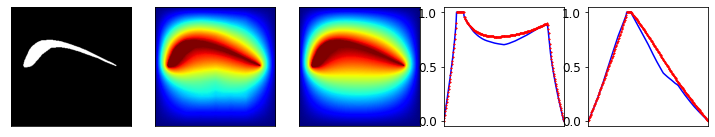

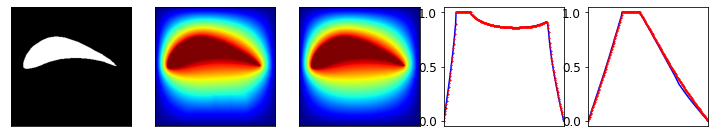

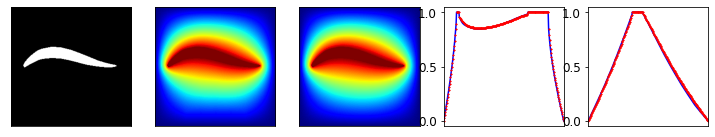

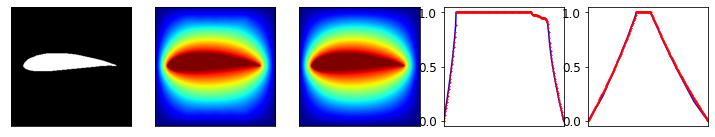

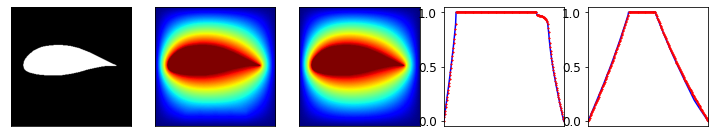

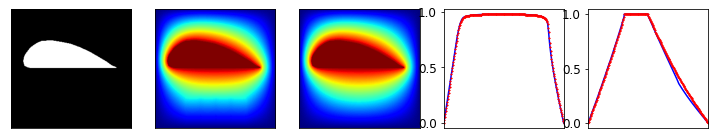

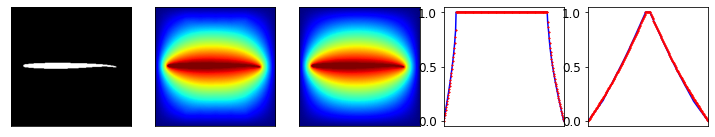

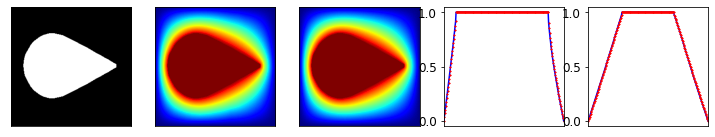

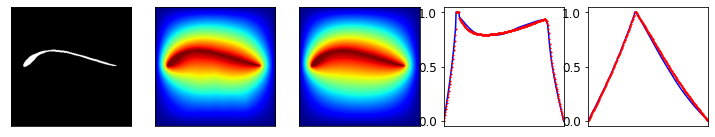

<Figure size 432x288 with 0 Axes>

In [100]:
for i in range(nsample):
    # core query code
    nu = nu_par_list[i]
    u_par = u_par_list[i]
    u_single = u_single_list[i]
    
    # plotting
    num_query = 1
    plt_num_row = num_query
    plt_num_col = 5
    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(2.5*plt_num_col,2.2*plt_num_row),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=False, squeeze=True)
#     fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(2*plt_num_col,2*plt_num_row),
#                         subplot_kw={'aspect': 'auto'},sharey=True)
    #fig.tight_layout()
#     for ax in axs:        
#         ax.set_xticks([])
#         ax.set_yticks([])
    for i in range(3):
            axs[i].set_xticks([])
            axs[i].set_yticks([])

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        im0 = axs[0].imshow(nu,cmap='gray_r',aspect="auto")
#         cb = fig.colorbar(im0, ax=axs[0], fraction=0.04, pad=0.1,orientation="horizontal")
#         cb.set_ticks([0,1])
#         cb.set_ticklabels([0,1])
        im1 = axs[1].imshow(u_par,cmap='jet',aspect="auto")
#         fig.colorbar(im1, ax=axs[1], fraction=0.04, pad=0.1,orientation="horizontal") 
        im2 = axs[2].imshow(u_single,cmap='jet',aspect="auto")
#         fig.colorbar(im2, ax=axs[2], fraction=0.04, pad=0.1,orientation="horizontal") 
        rowid = 128
        colid = 128
        im = axs[3].plot(u_par[rowid,:], 'b-')
        im = axs[3].plot(u_single[rowid,:], 'r*',markersize=1.5)
        im = axs[4].plot(u_par[:,colid], 'b-')
        im = axs[4].plot(u_single[:,colid], 'r*',markersize=1.5)
    # plt.close('all')
#     plt.tight_layout()
#     fig.subplots_adjust(bottom=0, top=0, left=0, right=0)
    plt.savefig(os.path.join(query_out_path,'q_'+str(i)+'.png'))
    plt.show()    
plt.savefig(os.path.join(query_out_path,'q_all-1.png'))
plt.show() 

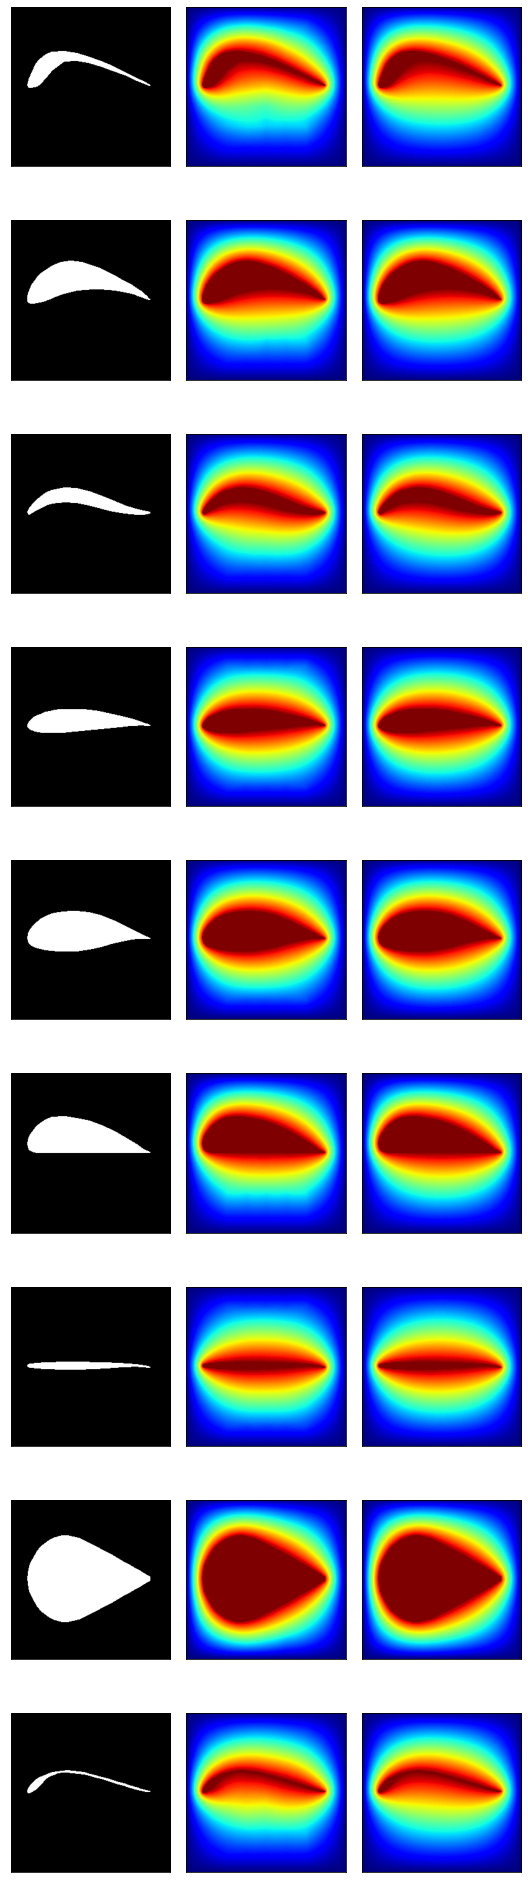

In [76]:
# plotting
num_query = 1
plt_num_row = nsample
plt_num_col = 3
fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(2.5*plt_num_col,3*plt_num_row),
                    subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
#     fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(2*plt_num_col,2*plt_num_row),
#                         subplot_kw={'aspect': 'auto'},sharey=True)
#fig.tight_layout()
for ax_row in axs:        
    for ax in ax_row:
        ax.set_xticks([])
        ax.set_yticks([])

for i in range(nsample):
    # core query code
    nu = nu_par_list[i]
    u_par = u_par_list[i]
    u_single = u_single_list[i]

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        im0 = axs[i,0].imshow(nu,cmap='gray_r')
#         cb = fig.colorbar(im0, ax=axs[i,0], fraction=0.04, pad=0.1,orientation="horizontal")
#         cb.set_ticks([0,1])
#         cb.set_ticklabels([0,1])
        im1 = axs[i,1].imshow(u_par,cmap='jet')
#         fig.colorbar(im1, ax=axs[i,1], fraction=0.04, pad=0.1,orientation="horizontal") 
        im2 = axs[i,2].imshow(u_single,cmap='jet')
#         fig.colorbar(im2, ax=axs[i,2], fraction=0.04, pad=0.1,orientation="horizontal") 
    # plt.close('all')
plt.tight_layout()
plt.savefig(os.path.join(query_out_path,'q_all.png'))
# plt.subplot_tool()
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.4)
plt.show() 

In [58]:
example_id = 2
u_par = u_par_list[example_id]
u_single = u_single_list[example_id]

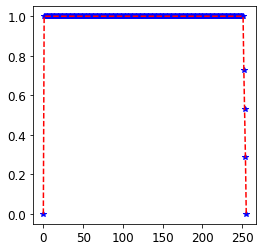

In [59]:
rowid = 128
fig = plt.figure(figsize=(4,4))
plt.plot(u_par[rowid,:], 'b*')
plt.plot(u_single[rowid,:],'r--')

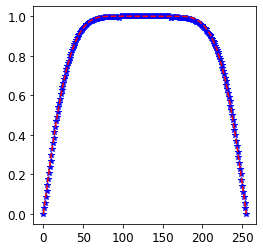

In [60]:
colid = 128
fig = plt.figure(figsize=(4,4))
plt.plot(u_par[:,colid], 'b*')
plt.plot(u_single[:,colid],'r--')

In [100]:
aa,bb=basecase.dataset[0]

In [101]:
aa.shape

torch.Size([3, 256, 256])

In [102]:
bb.shape

torch.Size([1, 256, 256])

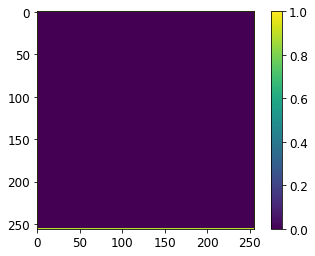

In [106]:
plt.imshow(aa[2])
plt.colorbar()